## **Imports** 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
from scipy import stats
import math
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest, chi2, f_classif, RFE, RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler


In [2]:
diab_df=pd.read_csv('/Users/vladandreichuk/Desktop/git_reps/Comparative-Analysis-of-ML-Algorithms-Predicting-Hospital-Readmission-of-Diabetes-Patients/CP_Hospital_Readmission/diab_df_cleaned.csv')

/var/folders/sd/m36c35x53hb666q0qqt92wk40000gn/T/ipykernel_31141/2634022902.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  diab_df=pd.read_csv('/Users/vladandreichuk/Desktop/git_reps/Comparative-Analysis-of-ML-Algorithms-Predicting-Hospital-Readmission-of-Diabetes-Patients/CP_Hospital_Readmission/diab_df_cleaned.csv')


In [3]:
diab_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100114 entries, 0 to 100113
Data columns (total 45 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   race                      100114 non-null  object
 1   gender                    100114 non-null  object
 2   age                       100114 non-null  object
 3   admission_type_id         100114 non-null  int64 
 4   discharge_disposition_id  100114 non-null  int64 
 5   admission_source_id       100114 non-null  int64 
 6   time_in_hospital          100114 non-null  int64 
 7   payer_code                60523 non-null   object
 8   num_lab_procedures        100114 non-null  int64 
 9   num_procedures            100114 non-null  int64 
 10  num_medications           100114 non-null  int64 
 11  number_inpatient          100114 non-null  int64 
 12  diag_1                    100114 non-null  object
 13  diag_2                    100114 non-null  object
 14  diag

## **Correlation Analysis**


In [4]:
# Select only the numeric columns for correlation analysis
num_cols_df= diab_df.select_dtypes(include=['number'])

# Calculate the correlation matrix for the numeric columns
correlation_matrix = num_cols_df.corr()

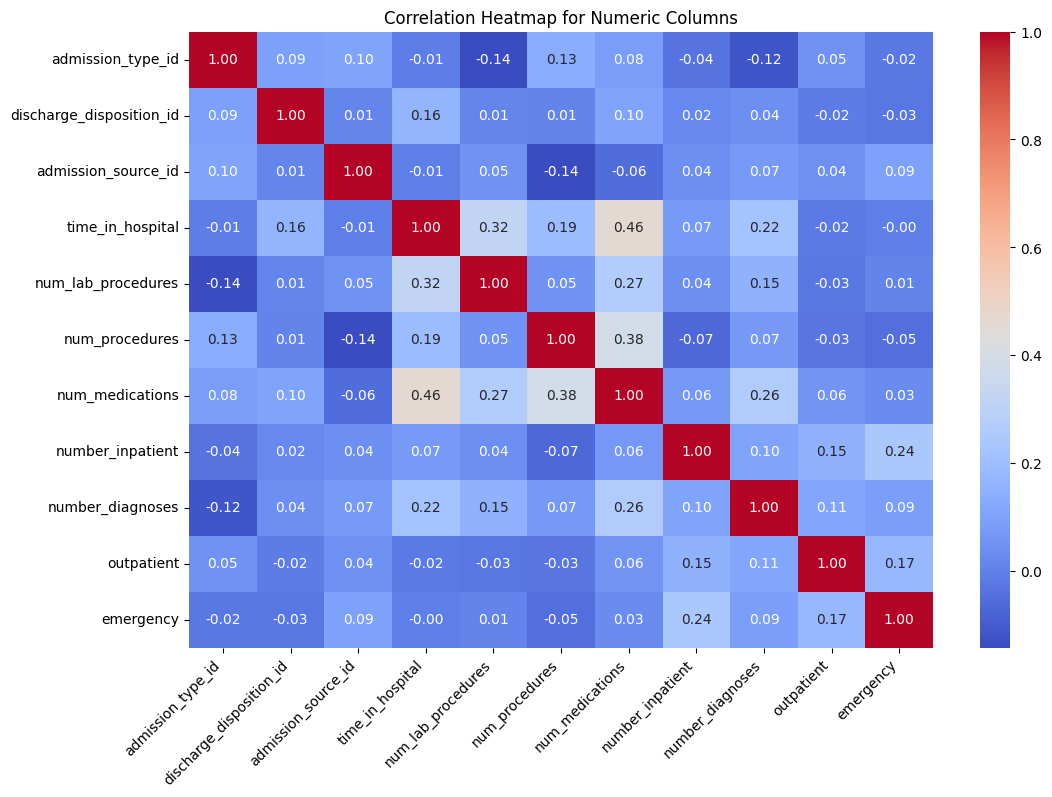

In [5]:
# Create a heatmap
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
# Rotate x-ticks
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right')
plt.title("Correlation Heatmap for Numeric Columns")
plt.show()

## **Chi2 Analysis**

### **Approach 1**

In [3]:
# Separate the target variable from the features
X = diab_df.drop(columns=['readmitted'])  # Features
y = diab_df['readmitted']  # Target variable

# Format all fields as string
X_str = X.astype(str)

# Encode input data
def encode_inputs(X):
    oe = OrdinalEncoder()
    oe.fit(X)
    X_enc = oe.transform(X)
    return X_enc


# Encode target variable
def encode_targets(y):
    le = LabelEncoder()
    le.fit(y)
    y_enc = le.transform(y)
    return y_enc

In [4]:
# Transform X
X_enc = encode_inputs(X_str)

# Transform y
y_enc = encode_targets(y)

In [8]:
# Calculate Chi-squared and P-value between features and the target variable
chi2_stat, chi2_p_values = chi2(X_enc, y_enc)

# Create a DataFrame to store the results
chi2_df = pd.DataFrame({'Feature': X.columns, 'Chi2': chi2_stat,'P_value': chi2_p_values})

# Sort the DataFrame by Chi2 values in ascending order
chi2_df = chi2_df.sort_values(by='Chi2', ascending=True)


print(chi2_df)


                     Feature          Chi2        P_value
30                  miglitol      0.001568   9.992162e-01
21            chlorpropamide      0.003924   9.980398e-01
34       glyburide-metformin      0.006904   9.965540e-01
20               nateglinide      0.012697   9.936715e-01
29                  acarbose      0.094443   9.538761e-01
22               glimepiride      0.423519   8.091594e-01
0                       race      0.528149   7.679165e-01
19               repaglinide      0.681806   7.111279e-01
25                 glyburide      0.772954   6.794464e-01
33                   insulin      0.838093   6.576735e-01
17                 A1Cresult      0.869906   6.472951e-01
38    metformin-pioglitazone      0.881418   6.435800e-01
26               tolbutamide      1.132636   5.676116e-01
28             rosiglitazone      1.200010   5.488089e-01
16             max_glu_serum      1.210253   5.460054e-01
27              pioglitazone      1.326393   5.152018e-01
31            

In [9]:
# Visualize the Chi2 values for each feature on a log scale in ascending order
fig = px.bar(chi2_df,x = 'Feature', y = 'Chi2',log_y=True)
fig.update_layout(title="Chi-squared values for all features and 'readmitted' target variable", yaxis_title="Chi2 (Log10 scale)",xaxis_title="Features") 
fig.update_xaxes(tickangle=-45)

In [10]:
# Select the columns to drop with high p-value and low Chi2
cols_to_drop_chi2_1= chi2_df[(chi2_df['P_value']>=0.05) | (chi2_df['Chi2']<=15)]['Feature'].tolist()
cols_to_drop_chi2_1

['miglitol',
 'chlorpropamide',
 'glyburide-metformin',
 'nateglinide',
 'acarbose',
 'glimepiride',
 'race',
 'repaglinide',
 'glyburide',
 'insulin',
 'A1Cresult',
 'metformin-pioglitazone',
 'tolbutamide',
 'rosiglitazone',
 'max_glu_serum',
 'pioglitazone',
 'troglitazone',
 'metformin-rosiglitazone',
 'glimepiride-pioglitazone',
 'acetohexamide',
 'glipizide-metformin',
 'tolazamide',
 'glipizide',
 'diag_2']

### **Approach 2**

In [11]:
# Alternative method to the above using SelectKBest
def skb_chi2(X, y):
    fs = SelectKBest(score_func=chi2, k='all')
    fs.fit(X, y)
    return fs

In [12]:
results_scores =[]
# Get the Chi2 results
for i in range(100):
    results = skb_chi2(X_enc, y_enc)
    results_scores.append(results.scores_)

skb_chi2_results = np.mean(results_scores,axis=0)    

In [13]:
# Print all the Chi2 values for all features
for i in range(len(skb_chi2_results)):
    print(f"Feature {X.columns[i]}: {skb_chi2_results[i]}")

# Visualize the Chi2 values for each feature on a log scale in ascending order
fig = px.bar(x=X.columns, y=skb_chi2_results, log_y=True)
fig.update_layout(
    xaxis={"categoryorder": "total ascending"},
    title="Chi-squared values for all features and 'readmitted' target variable",
    yaxis_title="Chi2 (Log10 scale)",
    xaxis_title="Features",
)
fig.update_xaxes(tickangle=-45)

Feature race: 0.5281485132902474
Feature gender: 17.701684662893282
Feature age: 65.01704411327704
Feature admission_type_id: 36.05268576452682
Feature discharge_disposition_id: 6845.741609933168
Feature admission_source_id: 1072.4761047576173
Feature time_in_hospital: 587.0374213661348
Feature payer_code: 23.31610197958601
Feature num_lab_procedures: 1632.573002136673
Feature num_procedures: 365.0341639629835
Feature num_medications: 7902.297485564031
Feature number_inpatient: 51410.2548124213
Feature diag_1: 88.63384777128523
Feature diag_2: 6.55471909676412
Feature diag_3: 44.77728023989551
Feature number_diagnoses: 430.3448154281143
Feature max_glu_serum: 1.2102526606666404
Feature A1Cresult: 0.8699059498732272
Feature metformin: 20.701645825753932
Feature repaglinide: 0.68180584690846
Feature nateglinide: 0.01269724862147374
Feature chlorpropamide: 0.00392414800468605
Feature glimepiride: 0.4235187670503276
Feature acetohexamide: 1.8165424110286488
Feature glipizide: 2.33026013085

In [14]:
# Create a temporary DataFrame to store the results 
chi2_results_df = pd.DataFrame({'Feature': X.columns,
                                'Chi-squared Statistic': skb_chi2_results})

In [15]:
# Sort rows by the Chi2 values in ascending order
chi2_results_df_sorted = chi2_results_df.sort_values(by='Chi-squared Statistic',ascending=True)

In [16]:
# Select 23 features (to match the size of the previous result) with lowest Chi2
cols_to_drop_chi2_2 = list(chi2_results_df_sorted[:23]['Feature'])
cols_to_drop_chi2_2

['miglitol',
 'chlorpropamide',
 'glyburide-metformin',
 'nateglinide',
 'acarbose',
 'glimepiride',
 'race',
 'repaglinide',
 'glyburide',
 'insulin',
 'A1Cresult',
 'metformin-pioglitazone',
 'tolbutamide',
 'rosiglitazone',
 'max_glu_serum',
 'pioglitazone',
 'troglitazone',
 'metformin-rosiglitazone',
 'glimepiride-pioglitazone',
 'acetohexamide',
 'glipizide-metformin',
 'tolazamide',
 'glipizide']

## **Mutual Information Analysis**

### **Approach 1**

In [17]:
# Calculate mutual information between features and the target variable
mutual_info = mutual_info_classif(X_enc, y_enc)

# Create a DataFrame to store the results
mutual_info_df = pd.DataFrame({'Feature': X.columns, 'Mutual_Info': mutual_info})

# Sort the DataFrame by mutual information values in ascending order
mutual_info_df = mutual_info_df.sort_values(by='Mutual_Info', ascending=True)

print(mutual_info_df)

                     Feature  Mutual_Info
35       glipizide-metformin     0.000000
36  glimepiride-pioglitazone     0.000000
37   metformin-rosiglitazone     0.000000
38    metformin-pioglitazone     0.000000
23             acetohexamide     0.000000
32                tolazamide     0.000414
14                    diag_3     0.000714
41                  outliers     0.001116
31              troglitazone     0.001152
13                    diag_2     0.001156
26               tolbutamide     0.001326
3          admission_type_id     0.001663
9             num_procedures     0.001672
8         num_lab_procedures     0.001757
6           time_in_hospital     0.001909
17                 A1Cresult     0.002399
2                        age     0.002552
12                    diag_1     0.002973
7                 payer_code     0.003839
18                 metformin     0.005531
28             rosiglitazone     0.005636
39                    change     0.005816
27              pioglitazone     0

In [18]:
# Visualize the MI values for each feature in ascending order
fig = px.bar(mutual_info_df, x = 'Feature', y = 'Mutual_Info')
fig.update_layout(title="Mutual Information values for all features and 'readmitted' target variable", yaxis_title="Mutual information",xaxis_title="Features") 
fig.update_xaxes(tickangle=-45)

In [19]:
# Select 23 features (to match the size of the previous result) with lowest Mutual Information
cols_to_drop_mi_1 = list(mutual_info_df[:23]['Feature'])
cols_to_drop_mi_1

['glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'acetohexamide',
 'tolazamide',
 'diag_3',
 'outliers',
 'troglitazone',
 'diag_2',
 'tolbutamide',
 'admission_type_id',
 'num_procedures',
 'num_lab_procedures',
 'time_in_hospital',
 'A1Cresult',
 'age',
 'diag_1',
 'payer_code',
 'metformin',
 'rosiglitazone',
 'change',
 'pioglitazone']

### **Approach 2**

In [20]:
# Alternative method to the above using SelectKBest
def skb_mut_inf(X, y):
    fs = SelectKBest(score_func=mutual_info_classif, k='all')
    fs.fit(X, y)
    return fs

In [21]:
results_scores =[]

# Get the MI results
for i in range(10):
    results = skb_mut_inf(X_enc, y_enc)
    results_scores.append(results.scores_)

skb_mi_results = np.mean(results_scores,axis=0)    

In [22]:
# Show the scores for the features
for i in range(len(skb_mi_results)):
    print(f"Feature {X.columns[i]}: {skb_mi_results[i]}")

# Visualize the MI values for each feature in ascending order
fig = px.bar(x=X.columns, y=skb_mi_results)
fig.update_layout(
    xaxis={"categoryorder": "total ascending"},
    title="MI values for all features and 'readmitted' target variable",
    yaxis_title="Mutual information",
    xaxis_title="Features",
)
fig.update_xaxes(tickangle=-45)

Feature race: 0.008226766011733933
Feature gender: 0.005334949722372762
Feature age: 0.003386321793252445
Feature admission_type_id: 0.0030320258034226997
Feature discharge_disposition_id: 0.01131748090366067
Feature admission_source_id: 0.012258468256761445
Feature time_in_hospital: 0.0033054791708385656
Feature payer_code: 0.0059274556015322276
Feature num_lab_procedures: 0.0031304440843116232
Feature num_procedures: 0.001719489212026537
Feature num_medications: 0.005410519312093132
Feature number_inpatient: 0.03298700363898097
Feature diag_1: 0.0032158424045498402
Feature diag_2: 0.002790469045959565
Feature diag_3: 0.0028120198685807284
Feature number_diagnoses: 0.010443647992044957
Feature max_glu_serum: 0.00713769507020059
Feature A1Cresult: 0.005992318211006431
Feature metformin: 0.0069637046109909395
Feature repaglinide: 0.006904457708980449
Feature nateglinide: 0.009742047666131803
Feature chlorpropamide: 0.006107917923043304
Feature glimepiride: 0.011138480204592738
Feature a

In [23]:
# Create a temporary DataFrame to store the results 
mi_results_df = pd.DataFrame({'Feature': X.columns,
                                  'MI Statistic': skb_mi_results})

In [24]:
# Sort rows by the MI values in ascending order
mi_results_df_sorted = mi_results_df.sort_values(by='MI Statistic',ascending=True)

In [25]:
# Select 23 features (to match the size of the previous result) with lowest MI
cols_to_drop_mi_2 = list(mi_results_df_sorted[:23]['Feature'])
cols_to_drop_mi_2

['tolbutamide',
 'metformin-pioglitazone',
 'tolazamide',
 'metformin-rosiglitazone',
 'troglitazone',
 'glipizide-metformin',
 'acetohexamide',
 'glimepiride-pioglitazone',
 'num_procedures',
 'diag_2',
 'diag_3',
 'admission_type_id',
 'num_lab_procedures',
 'diag_1',
 'time_in_hospital',
 'age',
 'outliers',
 'gender',
 'num_medications',
 'pioglitazone',
 'payer_code',
 'A1Cresult',
 'chlorpropamide']

## **ANOVA f-test**

### **Approach 1**

In [26]:
# Calculate the F-statistic and p-values for each feature
f_values, p_values = f_classif(X_enc, y_enc)

# Create a DataFrame to store the results
anova_f_df = pd.DataFrame({'Feature': X.columns, 'F_Value': f_values, 'P_Value': p_values})

# Sort the DataFrame by F-values in ascending order
anova_f_df = anova_f_df.sort_values(by='F_Value', ascending=True)

print(anova_f_df)

                     Feature      F_Value        P_Value
38    metformin-pioglitazone     0.440704   6.435845e-01
34       glyburide-metformin     0.485190   6.155820e-01
26               tolbutamide     0.566426   5.675519e-01
0                       race     0.603430   5.469346e-01
31              troglitazone     0.691274   5.009398e-01
33                   insulin     0.837905   4.326190e-01
20               nateglinide     0.839736   4.318275e-01
37   metformin-rosiglitazone     0.881424   4.141957e-01
36  glimepiride-pioglitazone     0.908270   4.032247e-01
23             acetohexamide     0.908270   4.032247e-01
35       glipizide-metformin     0.956314   3.843104e-01
32                tolazamide     1.095368   3.344206e-01
13                    diag_2     1.179610   3.074030e-01
30                  miglitol     1.784932   1.678138e-01
21            chlorpropamide     1.910276   1.480449e-01
17                 A1Cresult     3.044384   4.763005e-02
25                 glyburide   

In [27]:
# Visualize the F-test results for all features
fig = px.bar(anova_f_df, x = 'Feature', y = 'F_Value')
fig.update_layout(title="ANOVA f-test values for all features and 'readmitted' target variable", yaxis_title="F-test value",xaxis_title="Features") 
fig.update_xaxes(tickangle=-45)

In [28]:
# Select the columns to drop with high p-value and low f_value
cols_to_drop_anova_f_1= anova_f_df[(anova_f_df['P_Value']>=0.05) | (anova_f_df['F_Value']<=11)]['Feature'].tolist()
cols_to_drop_anova_f_1

['metformin-pioglitazone',
 'glyburide-metformin',
 'tolbutamide',
 'race',
 'troglitazone',
 'insulin',
 'nateglinide',
 'metformin-rosiglitazone',
 'glimepiride-pioglitazone',
 'acetohexamide',
 'glipizide-metformin',
 'tolazamide',
 'diag_2',
 'miglitol',
 'chlorpropamide',
 'A1Cresult',
 'glyburide',
 'glimepiride',
 'payer_code',
 'diag_3',
 'admission_type_id',
 'pioglitazone',
 'glipizide',
 'rosiglitazone']

### **Approach 2**

In [29]:
# Alternative method to the above using SelectKBest
def skb_anova_f(X, y):
    fs = SelectKBest(score_func=f_classif, k='all')
    fs.fit(X, y)
    return fs

In [30]:
results_scores =[]

# Get the F-test results
for i in range(100):
    results = skb_anova_f(X_enc, y_enc)
    results_scores.append(results.scores_)

skb_anova_f_results = np.mean(results_scores,axis=0)    

In [31]:
# Show the scores for the features
for i in range(len(skb_anova_f_results)):
    print(f"Feature {X.columns[i]}: {skb_anova_f_results[i]}")

# Visualize the ANOVA f-test values for each feature in ascending order
fig = px.bar(x=X.columns, y=skb_anova_f_results)
fig.update_layout(
    xaxis={"categoryorder": "total ascending"},
    title="ANOVA f-test values for all features and 'readmitted' target variable",
    yaxis_title="ANOVA f-test values",
    xaxis_title="Features",
)
fig.update_xaxes(tickangle=-45)

Feature race: 0.603429611808593
Feature gender: 16.4533451693701
Feature age: 77.87664089701343
Feature admission_type_id: 8.866441436918869
Feature discharge_disposition_id: 333.59206271197405
Feature admission_source_id: 123.07264327645558
Feature time_in_hospital: 154.5059357708724
Feature payer_code: 4.1116071878293505
Feature num_lab_procedures: 97.27977794061859
Feature num_procedures: 84.15274849521303
Feature num_medications: 152.5346193242675
Feature number_inpatient: 2596.289382138493
Feature diag_1: 16.67717296339622
Feature diag_2: 1.179609621917958
Feature diag_3: 8.089711843407487
Feature number_diagnoses: 711.7874501720363
Feature max_glu_serum: 12.6322454784256
Feature A1Cresult: 3.0443840791944354
Feature metformin: 64.81334978402354
Feature repaglinide: 18.943103700490553
Feature nateglinide: 0.8397361052825636
Feature chlorpropamide: 1.9102762501918298
Feature glimepiride: 3.801220871662339
Feature acetohexamide: 0.9082695410722674
Feature glipizide: 9.77021656383553

In [32]:
# Create a temporary DataFrame to store the results 
anova_f_results_df = pd.DataFrame({'Feature': X.columns,
                                'ANOVA f-test Statistic': skb_anova_f_results})

In [33]:
# Sort rows by the F values in ascending order
anova_f_results_df_sorted = anova_f_results_df.sort_values(by='ANOVA f-test Statistic',ascending=True)

In [34]:
# Select 23 features (to match the size of the previous result) with lowest F values
cols_to_drop_anova_f_2 = list(anova_f_results_df_sorted[:23]['Feature'])
cols_to_drop_anova_f_2

['metformin-pioglitazone',
 'glyburide-metformin',
 'tolbutamide',
 'race',
 'troglitazone',
 'insulin',
 'nateglinide',
 'metformin-rosiglitazone',
 'glimepiride-pioglitazone',
 'acetohexamide',
 'glipizide-metformin',
 'tolazamide',
 'diag_2',
 'miglitol',
 'chlorpropamide',
 'A1Cresult',
 'glyburide',
 'glimepiride',
 'payer_code',
 'diag_3',
 'admission_type_id',
 'pioglitazone',
 'glipizide']

## **Recursive Feature Elimination (RFE)**

In [5]:
def rfe_fs(X, y, col_names, estimator, k):
    """
    Perform Recursive Feature Elimination (RFE) for feature selection.

    Parameters:
      X (array-like or pd.DataFrame): The feature matrix.
      y (array-like or pd.Series): The target variable.
      col_names (list): List of column names corresponding to the features in X.
      estimator: The external estimator object that assigns weights to features.
      k (int): The number of features to select.

    Returns:
      selector (RFE): The trained RFE selector.
      deleted_features (list): List of column names to be deleted (least important features).
      feature_importances (pd.DataFrame): DataFrame containing feature importances.
    """
    # Initialize RFE with the estimator and the number of features to select
    selector = RFE(estimator, n_features_to_select=k)

    # Fit RFE to the dataset with a progress bar
    with tqdm(total=k, desc="RFE Progress") as pbar:
        for step in range(k):
            selector.fit(X, y)
            # Update the progress bar
            pbar.update(1)

    # Get the list of columns to delete (least important features)
    deleted_features = col_names[~selector.support_]

    # Create a DataFrame of feature importances
    feature_importances = pd.DataFrame(
        {"Feature": col_names, "Ranking": selector.ranking_}
    )

    # Sort the DataFrame by importance (ascending order) to arrange features from least important to most important
    feature_importances = feature_importances.sort_values(
        by="Ranking", ascending=True
    )

    return selector, deleted_features, feature_importances

In [36]:
rfe_model, cols_to_drop_rfe, rfe_results_df = rfe_fs(X_enc,y_enc,X.columns,estimator=RandomForestClassifier(), k=23)

RFE Progress:   0%|          | 0/23 [00:00<?, ?it/s]

RFE Progress: 100%|██████████| 23/23 [2:54:43<00:00, 455.82s/it]  


In [37]:
# Create a bar chart to visualize RFE feature ranks
fig = px.bar(rfe_results_df, x="Feature", y="Importance")
fig.update_layout(
    title="Feature Ranks (RFE)",
    yaxis_title="Ranke",
    xaxis_title="Features",
    xaxis={
        "categoryorder": "total descending"
    },  # Arrange features from least to most important
)
fig.update_xaxes(tickangle=-45)
fig.show()

# Print the list of deleted feature names
print("Features to drop:")
print(cols_to_drop_rfe)

Features to drop:
Index(['max_glu_serum', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'tolbutamide', 'rosiglitazone',
       'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'diabetesMed', 'outliers', 'outpatient',
       'emergency'],
      dtype='object')


## **Lasso**

In [38]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X_enc)

In [39]:
def lasso_fs(X, y, col_names, params, n_splits):
    """
    Perform feature selection using Lasso regression.

    Parameters:
      X (pd.DataFrame): The feature matrix.
      y (pd.Series): The target variable.
      col_names (list): List of column names in the feature matrix.
      params (dict): Dictionary of hyperparameters for Lasso regression.
      n_splits (int): Number of folds for cross-validation.

    Returns:
    tuple: A tuple containing the Lasso model, DataFrame with feature importances,
           and a list of excluded feature names (least important features).
    """

    # Number of Folds and adding the random state for replication
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Initializing the Model
    model = Lasso(max_iter=1000)

    # GridSearchCV with model, params and folds.
    lasso_gs = GridSearchCV(model, param_grid=params, cv=kf)
    lasso_gs.fit(X, y)

    # Fit the model with the optimal parameters
    lasso = Lasso(alpha=lasso_gs.best_params_["alpha"], max_iter=1000)

    lasso.fit(X_enc, y_enc)

    # Get the coefficients (feature importances)
    feature_importances = np.abs(lasso.coef_)

    # Create a DataFrame to store the feature importances
    feature_importances_df = pd.DataFrame(
        {"Feature": col_names, "Importance": feature_importances}
    )

    # Sort the DataFrame by importance (ascending order) to arrange features from less important to most important
    feature_importances_df = feature_importances_df.sort_values(
        by="Importance", ascending=True
    )

    # Get the list of columns to exclude (least important features)
    excluded_feature_names = feature_importances_df[
        feature_importances_df["Importance"] == 0
    ]["Feature"]

    return lasso, feature_importances_df, list(excluded_feature_names)


In [40]:
# parameters to be tested on GridSearchCV
params = {"alpha":np.arange(0.00001, 10, 500)}

# Perform Lasso Regression and extract the fetures with coefficients of 0
lasso_model, lasso_results_df , cols_to_drop_lasso = lasso_fs(X_scaled, y_enc, col_names=X.columns,params=params,n_splits=10)

In [41]:
# Create a bar chart to visualize feature importances
fig = px.bar(lasso_results_df, x="Feature", y="Importance")
fig.update_layout(
    title="Feature Importances (Lasso)",
    yaxis_title="Importance",
    xaxis_title="Features",
    xaxis={
        "categoryorder": "total ascending"
    },  # Arrange features from less important to most important
)
fig.update_xaxes(tickangle=-45)
fig.show()

# Print the list of deleted feature names
print("Features to drop:")
print(cols_to_drop_lasso)

Features to drop:
['glimepiride-pioglitazone', 'troglitazone', 'glipizide-metformin', 'metformin-pioglitazone', 'acetohexamide']


## **Summary**

In [42]:
# Create a temporary DataFrame to store the results for this column
fs_total_results_df = pd.DataFrame({'Feature': X.columns,
                                  'Chi2': [True if x in cols_to_drop_chi2_1 else False for x in X.columns],
                                  'Chi2_SelectKBest': [True if x in cols_to_drop_chi2_2 else False for x in X.columns],
                                  'MI': [True if x in cols_to_drop_mi_1 else False for x in X.columns],
                                  'MI_SelectKBest': [True if x in cols_to_drop_mi_2 else False for x in X.columns],
                                  'ANOVA_f-test': [True if x in cols_to_drop_anova_f_1 else False for x in X.columns] ,
                                  'ANOVA_f-tes_SelectKBest': [True if x in cols_to_drop_anova_f_2 else False for x in X.columns],
                                  'RFE': [True if x in cols_to_drop_rfe else False for x in X.columns],
                                  'Lasso': [True if x in cols_to_drop_lasso else False for x in X.columns]})

In [43]:
fs_total_results_df

,Feature,Chi2,Chi2_SelectKBest,MI,MI_SelectKBest,ANOVA_f-test,ANOVA_f-tes_SelectKBest,RFE,Lasso
0,race,True,True,False,False,True,True,False,False
1,gender,False,False,False,True,False,False,False,False
2,age,False,False,True,True,False,False,False,False
3,admission_type_id,False,False,True,True,True,True,False,False
4,discharge_disposition_id,False,False,False,False,False,False,False,False
5,admission_source_id,False,False,False,False,False,False,False,False
6,time_in_hospital,False,False,True,True,False,False,False,False
7,payer_code,False,False,True,True,True,True,False,False
8,num_lab_procedures,False,False,True,True,False,False,False,False
9,num_procedures,False,False,True,True,False,False,False,False


In [44]:
fs_total_results_df['Matches'] = fs_total_results_df.iloc[:,1:].sum(axis=1)


In [45]:
fs_total_results_df.head()

,Feature,Chi2,Chi2_SelectKBest,MI,MI_SelectKBest,ANOVA_f-test,ANOVA_f-tes_SelectKBest,RFE,Lasso,Matches
0,race,True,True,False,False,True,True,False,False,4
1,gender,False,False,False,True,False,False,False,False,1
2,age,False,False,True,True,False,False,False,False,2
3,admission_type_id,False,False,True,True,True,True,False,False,4
4,discharge_disposition_id,False,False,False,False,False,False,False,False,0


In [51]:
# Select features that were selected at least 3 times
cols_to_drop = fs_total_results_df[(fs_total_results_df['Matches']>=5)&(fs_total_results_df['RFE']==True)]['Feature']

In [52]:
cols_to_drop

20                 nateglinide
21              chlorpropamide
22                 glimepiride
23               acetohexamide
26                 tolbutamide
28               rosiglitazone
30                    miglitol
31                troglitazone
32                  tolazamide
34         glyburide-metformin
35         glipizide-metformin
36    glimepiride-pioglitazone
37     metformin-rosiglitazone
38      metformin-pioglitazone
Name: Feature, dtype: object

In [53]:
# Drop the identified features
diab_df_filtered = diab_df.drop(columns = cols_to_drop)

In [54]:
diab_df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100114 entries, 0 to 100113
Data columns (total 31 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   race                      100114 non-null  object
 1   gender                    100114 non-null  object
 2   age                       100114 non-null  object
 3   admission_type_id         100114 non-null  int64 
 4   discharge_disposition_id  100114 non-null  int64 
 5   admission_source_id       100114 non-null  int64 
 6   time_in_hospital          100114 non-null  int64 
 7   payer_code                60523 non-null   object
 8   num_lab_procedures        100114 non-null  int64 
 9   num_procedures            100114 non-null  int64 
 10  num_medications           100114 non-null  int64 
 11  number_inpatient          100114 non-null  int64 
 12  diag_1                    100114 non-null  object
 13  diag_2                    100114 non-null  object
 14  diag

In [55]:
# Save the filtered data
diab_df_filtered.to_csv('diab_df_filtered.csv', index=False) 